<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/ansonkwokth/TableTennisPrediction.git
%cd TableTennisPrediction

fatal: destination path 'TableTennisPrediction' already exists and is not an empty directory.
/content/TableTennisPrediction


In [5]:
import pandas as pd
from utils import data_loader as dl

import numpy as np
from model.Elo import Elo
from model.ModifiedElo import ModifiedElo
from model.ensemble import BaggingRatingSystem

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import copy

import warnings
warnings.filterwarnings('ignore')

# Data

In [6]:
# GAME = 'TTStar'
# GAME = 'TTCup'
# GAME = 'SetkaCup'
GAME = 'SetkaCupWomen'
# GAME = 'LigaPro'


In [7]:
match GAME:
    case 'TTStar':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'TTCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCupWomen':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'LigaPro':
        years = [2022, 2023, 2024]
    case _:
        raise ValueError("Invalid game selected.")


text_data_game = dl.load_game_data(GAME, years, '../')
text_data = {
    year: text_data_game[year] for year in years
}
df = dl.create_game_dfs(GAME, years, text_data)

Loading ..//SetkaCupWomen2020.txt
Loading ..//SetkaCupWomen2021.txt
Loading ..//SetkaCupWomen2022.txt
Loading ..//SetkaCupWomen2023.txt
Loading ..//SetkaCupWomen2024.txt


In [8]:
# Generate ID indices for each pair of rows in the DataFrame
idx_lt = [i for i in range(len(df) // 2) for _ in range(2)]
df['ID'] = idx_lt  # Assign to the 'ID' column

# Reset the DataFrame index to ensure it's sequential
df.reset_index(drop=True, inplace=True)

# Get unique players and store them in player_lt
player_lt = df['Player'].unique()



In [9]:
year_val = years[-2]
year_test = years[-1]

df_train = df.loc[pd.DatetimeIndex(df['Date']).year < year_val]
df_val = df.loc[pd.DatetimeIndex(df['Date']).year == year_val]
df_test = df.loc[pd.DatetimeIndex(df['Date']).year == year_test]

In [10]:
def format_to_array(df: pd.DataFrame) -> np.ndarray:

    # info_col = ['ID', 'Round', 'Datetime', 'Game', 'Date', 'Time']
    info_col = ['Round', 'Datetime', 'Game', 'Date', 'Time']
    col = [item for item in df.columns if item not in info_col]

    df[[c for c in col if "Set" in c]] = df[[c for c in col if "Set" in c]].astype(float)
    X = df[col].values.reshape(-1, 2, len(col))
    return X

In [11]:
X_train = format_to_array(df_train)
X_val = format_to_array(df_val)
X_test = format_to_array(df_test)

In [26]:
X_all = format_to_array(df)

# Train and Evaluate

In [12]:
# traditional Elo
modelElo = Elo()
# modified Elo
modelMElo = ModifiedElo()

# traing model with only training set
modelElo.fit(X_train)
modelMElo.fit(X_train)


Training model: 100%|██████████| 26120/26120 [00:01<00:00, 19225.62it/s]


In [13]:
# ensembleElo = BaggingRatingSystem(estimator=Elo(), n_models=10, sample_ratio=0.5)
# ensembleElo.fit(X_train)

In [14]:
# ensembleMElo = BaggingRatingSystem(estimator=ModifiedElo(), n_models=10, sample_ratio=0.5)
# ensembleMElo.fit(X_train)

In [15]:
def evaluate(model, dataset):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False
    correct = 0
    n_matches = 0

    history = []
    predictions = []
    for matchi in tqdm(dataset, desc="Evaluating matches"):
        matchi = matchi.T
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_game(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        win1 = sum(matchi[2:, 0]>matchi[2:, 1])
        win2 = sum(matchi[2:, 0]<matchi[2:, 1])
        whowon = 0 if win1 > win2 else 1

        history.append(win1/(win1 + win2))
        predictions.append(p)

        n_matches += 1
        if (whowon == whowillwin): correct += 1

    acc = correct / n_matches
    print(f'\n === Accuracy: {acc} === \n\n')
    return acc, np.array(history), np.array(predictions)



In [16]:
# evaluate the model with the training set
evaluate(modelElo, X_train);
evaluate(modelMElo, X_train);
# evaluate(ensembleElo, X_train);
# evaluate(ensembleMElo, X_train);


Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:00<00:00, 31492.17it/s]



 === Accuracy: 0.5256891271056662 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:00<00:00, 26636.51it/s]


 === Accuracy: 0.6153905053598775 === 




In [17]:
# evaluate the model with the evaluating set
evaluate(modelElo, X_val);
evaluate(modelMElo, X_val);
# evaluate(ensembleElo, X_val);
# evaluate(ensembleMElo, X_val);


Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 18753.79it/s]



 === Accuracy: 0.5358906190657046 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 23143.91it/s]


 === Accuracy: 0.5818458032662363 === 




In [18]:

# define a new model, and import the pre-trained params from the training set
modelElo_test = Elo(learning_rate=modelElo.learning_rate)
modelElo_test.params = modelElo.params

# training the model again with the evaluating set, on top of the pre-trained params
modelElo_test.fit(X_val)

Training model: 100%|██████████| 6490/6490 [00:00<00:00, 37539.42it/s]


In [19]:
# define a new model, and import the pre-trained params from the training set
modelMElo_test = ModifiedElo(learning_rate=modelMElo.learning_rate)
modelMElo_test.params = modelMElo.params

# training the model again with the evaluating set, on top of the pre-trained params
modelMElo_test.fit(X_val)

Training model: 100%|██████████| 6490/6490 [00:00<00:00, 19509.75it/s]


In [20]:
# X_train_val = np.append(X_train, X_val, axis=0)

# ensembleElo_test = BaggingRatingSystem(estimator=Elo(), n_models=10, sample_ratio=0.5)
# ensembleElo_test.fit(X_train_val)

In [21]:
# ensembleMElo_test = BaggingRatingSystem(estimator=ModifiedElo(), n_models=10, sample_ratio=0.5)
# ensembleMElo_test.fit(X_train_val)

In [22]:
# evaluate the model with the testing set
evaluate(modelElo_test, X_val);
evaluate(modelMElo_test, X_val);
# evaluate(ensembleElo_test, X_val);
# evaluate(ensembleMElo_test, X_val);

Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 18974.03it/s]



 === Accuracy: 0.5359013867488444 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 26336.11it/s]


 === Accuracy: 0.6220338983050847 === 




In [23]:
# evaluate the model with the testing set
accElo, historyElo, predictionsElo = evaluate(modelElo_test, X_test)
accMElo, historyMElo, predictionsMElo = evaluate(modelMElo_test, X_test)
# accenElo, historyenElo, predictionsenElo = evaluate(ensembleElo_test, X_test);
# accenMElo, historyenMElo, predictionsenMElo = evaluate(ensembleMElo_test, X_test);

Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 1969/1969 [00:00<00:00, 9056.31it/s]



 === Accuracy: 0.569060773480663 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 1969/1969 [00:00<00:00, 6653.02it/s] 


 === Accuracy: 0.6519337016574586 === 




Text(0, 0.5, 'Pred')

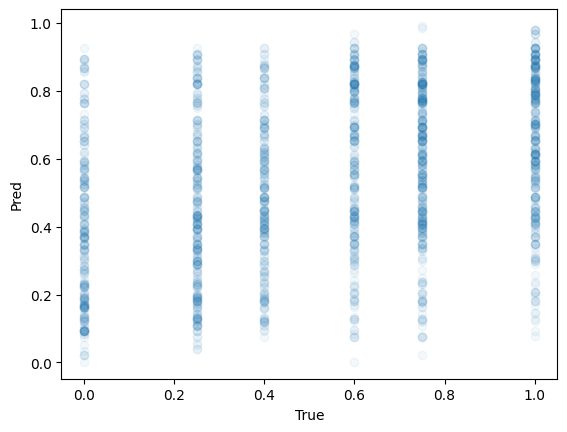

In [24]:
# plt.scatter(historyElo, predictionsElo, alpha=0.05)
plt.scatter(historyMElo, predictionsMElo, alpha=0.05)
# plt.scatter(historyenMElo, predictionsenMElo, alpha=0.05)
plt.xlabel("True")
plt.ylabel("Pred")

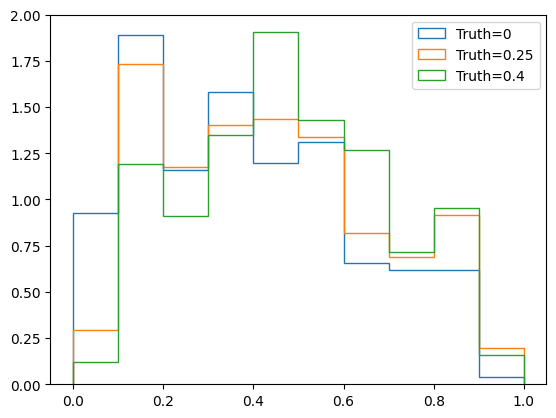

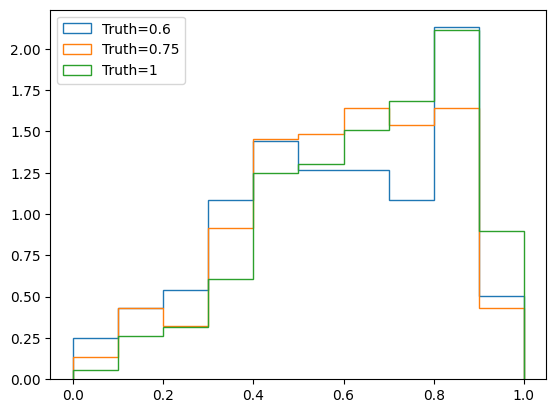

In [25]:
bins_=10
history_p = [0, 0.25, 0.4, 0.6, 0.75, 1]
for p in history_p[:3]:
    plt.hist(predictionsMElo[historyMElo == p], range=[0, 1], bins=bins_, histtype='step', density=True, label=f"Truth={p}");

plt.legend();
plt.show()

for p in history_p[3:]:
    plt.hist(predictionsMElo[historyMElo == p], range=[0, 1], bins=bins_, histtype='step', density=True, label=f"Truth={p}");

plt.legend();
plt.show()

# Inference

In [ ]:
player1 = 'Folwarski J.'
player2 = 'Brossier B.'

found_p1, found_p2, p_point = modelMElo_test.predict_point(player1, player2)
found_p1, found_p2, p_set = modelMElo_test.predict_set(player1, player2)
found_p1, found_p2, p_game = modelMElo_test.predict_game(player1, player2)

In [ ]:
print(f"p({player1} wins a point)  = {p_point:.4f}")
print(f"p({player1} wins a set)    = {p_set:.4f}")
print(f"p({player1} wins the game) = {p_game:.4f}")

p(Folwarski J. wins a point)  = 0.5318
p(Folwarski J. wins a set)    = 0.6215
p(Folwarski J. wins the game) = 0.7191


In [ ]:
found_p1, found_p2, ps_set = modelMElo_test.predict_set_config(player1, player2)

for points, p in ps_set.items():
    print(f"p({player1} wins a set with total points={points}) = {p:.4f}")

p(Folwarski J. wins a set with total points=11) = 0.0010
p(Folwarski J. wins a set with total points=12) = 0.0050
p(Folwarski J. wins a set with total points=13) = 0.0139
p(Folwarski J. wins a set with total points=14) = 0.0283
p(Folwarski J. wins a set with total points=15) = 0.0463
p(Folwarski J. wins a set with total points=16) = 0.0650
p(Folwarski J. wins a set with total points=17) = 0.0812
p(Folwarski J. wins a set with total points=18) = 0.0923
p(Folwarski J. wins a set with total points=19) = 0.0972
p(Folwarski J. wins a set with total points=20) = 0.0961
p(Folwarski J. wins a set with total points=22) = 0.0953


In [ ]:
# by defalt, who wins 3 sets will win the game
found_p1, found_p2, ps_game = modelMElo_test.predict_game_config(player1, player2)

for points, p in ps_game.items():
    print(f"p({player1} wins the game with total sets={points}) = {p:.4f}")

p(Folwarski J. wins the game with total sets=3) = 0.2401
p(Folwarski J. wins the game with total sets=4) = 0.2726
p(Folwarski J. wins the game with total sets=5) = 0.2063


In [ ]:
# if the rule of the game is: who wins 5 sets will win the game
n_win_sets = 5
found_p1, found_p2, ps_game = modelMElo_test.predict_game_config(player1, player2, n_win_sets)

for points, p in ps_game.items():
    print(f"p({player1} wins the game with total sets={points}) = {p:.4f}")

p(Folwarski J. wins the game with total sets=5) = 0.0928
p(Folwarski J. wins the game with total sets=6) = 0.1755
p(Folwarski J. wins the game with total sets=7) = 0.1993
p(Folwarski J. wins the game with total sets=8) = 0.1760
p(Folwarski J. wins the game with total sets=9) = 0.1332


In [27]:
# traditional Elo
modelMElo_all = ModifiedElo()

# traing model with only training set
modelMElo_all.fit(X_all)


Training model: 100%|██████████| 34579/34579 [00:02<00:00, 14734.24it/s]


In [89]:
player1 = 'Severina Y.'
player2 = 'Ivchenko O.'
o1 = 4.5
o2 = 1.16

found_p1, found_p2, p_game = modelMElo_all.predict_game(player1, player2)
if (found_p1 and found_p2):
    print(p_game, 1-p_game, p_game*o1, (1-p_game)*o2)

0.2183756553768238 0.7816243446231762 0.9826904491957071 0.9066842397628844


In [90]:
f"{player1} v {player2} -    {player1 if p_game>0.5 else player2}"


# Jan 24, 8:35 - Hordynska-Sheiko A. v Ivchenko O. -    Ivchenko O.
# Jan 24: 9:35 - Severina Y. v Gordeets M. -    Gordeets M.
# Jan 24: 10:35 - Gordeets M. v Ivchenko O. -    Ivchenko O.
# Jan 24: 11:05 - Lifanova O. v Severina Y. -    Lifanova O.
# Jan 24: 11:35 - Hordynska-Sheiko A. v Gordeets M. -    Gordeets M.
# Jan 24: 12:35 - Lifanova O. v Ivchenko O. -    Ivchenko O.
# Jan 24: 13:05 - Hordynska-Sheiko A. v Severina Y. -    Severina Y.
# Jan 24: 13:35 - Lifanova O. v Gordeets M. -    Lifanova O.
# Jan 24: 14:35 - Hordynska-Sheiko A. v Lifanova O. -    Lifanova O.
# Jan 24: 15:05 - Severina Y. v Ivchenko O. -    Ivchenko O.


'Severina Y. v Ivchenko O. -    Ivchenko O.'

In [73]:
p1_name = 'Lif'

for k, v in modelMElo_all.params.items():
    if p1_name in k:
        print(k, v)
        break

Lifanova O. (0.1264305899105458, 1.0138259669332161)
